<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Tuning de Hiperparâmetros

## Importação das bibliotecas

In [1]:
# Pacotes de preparação dos dados
import pandas as pd
import numpy as np
from math import sqrt
import random

# Pacotes gráficos
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Pacotes de Modelagem
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error

# Pacotes para Redes Neurais Artificiais
import tensorflow as tf # Para instalar o Tensorflow utilize: pip install tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor # Para instalar o scikeras utilize: pip install scikeras

# Para desabilitar suporte a GPU
# Necessário para paralelizar treinamento das RNAs
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Funções customizadas
import preditiva

## Importação da base de dados

In [2]:
df = pd.read_csv('house_prices_train.csv')
df = df[[
    'MSSubClass','HouseStyle','LotArea',
    'YearBuilt', 'MasVnrArea', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF','OverallCond','SalePrice']]
df.head()

,MSSubClass,HouseStyle,LotArea,YearBuilt,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,OverallCond,SalePrice
0,60,2Story,8450,2003,196.0,856,856,854,5,208500
1,20,1Story,9600,1976,0.0,1262,1262,0,8,181500
2,60,2Story,11250,2001,162.0,920,920,866,5,223500
3,70,2Story,9550,1915,0.0,756,961,756,5,140000
4,60,2Story,14260,2000,350.0,1145,1145,1053,5,250000


## Preparação dos Dados

### Missing Values

In [3]:
df.isnull().sum()

MSSubClass     0
HouseStyle     0
LotArea        0
YearBuilt      0
MasVnrArea     8
TotalBsmtSF    0
1stFlrSF       0
2ndFlrSF       0
OverallCond    0
SalePrice      0
dtype: int64

In [4]:
df.dropna(inplace=True)

### Duplicações

In [5]:
df.duplicated().sum()

1

In [6]:
df.loc[df.duplicated(keep=False)]

,MSSubClass,HouseStyle,LotArea,YearBuilt,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,OverallCond,SalePrice
145,160,2Story,2522,2004,50.0,970,970,739,5,130000
193,160,2Story,2522,2004,50.0,970,970,739,5,130000


### Tipos de Variáveis

In [7]:
df.head(2)

,MSSubClass,HouseStyle,LotArea,YearBuilt,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,OverallCond,SalePrice
0,60,2Story,8450,2003,196.0,856,856,854,5,208500
1,20,1Story,9600,1976,0.0,1262,1262,0,8,181500


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1452 non-null   int64  
 1   HouseStyle   1452 non-null   object 
 2   LotArea      1452 non-null   int64  
 3   YearBuilt    1452 non-null   int64  
 4   MasVnrArea   1452 non-null   float64
 5   TotalBsmtSF  1452 non-null   int64  
 6   1stFlrSF     1452 non-null   int64  
 7   2ndFlrSF     1452 non-null   int64  
 8   OverallCond  1452 non-null   int64  
 9   SalePrice    1452 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 124.8+ KB


In [9]:
# Conversão de variáveis numéricas em categóricas
df['MSSubClass'] = df['MSSubClass'].astype(object)
df['OverallCond'] = df['OverallCond'].astype(object)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1452 non-null   object 
 1   HouseStyle   1452 non-null   object 
 2   LotArea      1452 non-null   int64  
 3   YearBuilt    1452 non-null   int64  
 4   MasVnrArea   1452 non-null   float64
 5   TotalBsmtSF  1452 non-null   int64  
 6   1stFlrSF     1452 non-null   int64  
 7   2ndFlrSF     1452 non-null   int64  
 8   OverallCond  1452 non-null   object 
 9   SalePrice    1452 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 124.8+ KB


## Análise Exploratória dos Dados

### Dispersão com Regressão

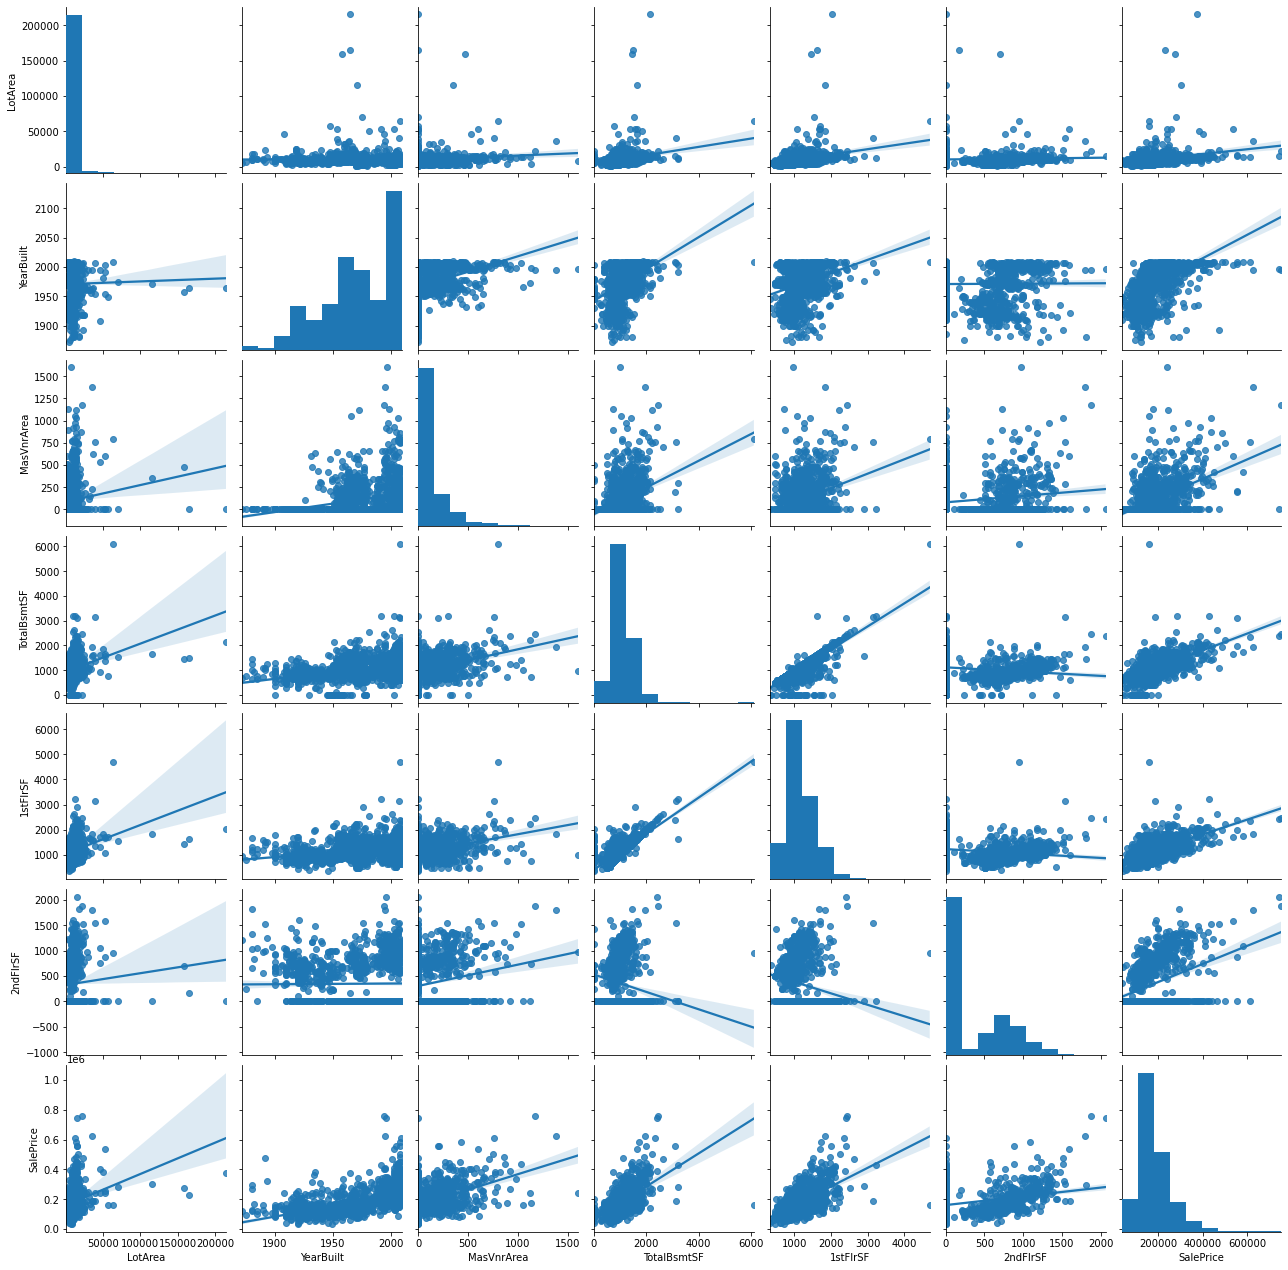

In [11]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

sns.pairplot(df.drop(['MSSubClass','HouseStyle','OverallCond'], axis=1),
             kind='reg');

### Relatórios Pandas Profiling e SweetViz

In [ ]:
perfil_pp, perfil_sv = preditiva.gera_relatorios_aed(df=df,
                                                     target_feat='SalePrice')
sns.reset_defaults()

## Desenvolvimento dos Modelos
Para desenvolvermos as Redes Neurais Artificiais utilizaremos uma das bibliotecas mais populares: [Tensorflow](https://www.tensorflow.org/?hl=pt-br)

### Definição do *Target* e das *Features*

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1452 non-null   object 
 1   HouseStyle   1452 non-null   object 
 2   LotArea      1452 non-null   int64  
 3   YearBuilt    1452 non-null   int64  
 4   MasVnrArea   1452 non-null   float64
 5   TotalBsmtSF  1452 non-null   int64  
 6   1stFlrSF     1452 non-null   int64  
 7   2ndFlrSF     1452 non-null   int64  
 8   OverallCond  1452 non-null   object 
 9   SalePrice    1452 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 157.1+ KB


In [13]:
# Target (variável resposta)
y_var = 'SalePrice'
y = df[[y_var]]

# Features (variáveis explicativas)
# Variáveis Numéricas
x_var_num = [
    'LotArea', 'YearBuilt', 'MasVnrArea', 
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'
    ]
x_num = df[x_var_num].to_numpy()

# Variáveis Categóricas / Qualitativas
x_var_cat = ['MSSubClass', 'HouseStyle', 'OverallCond']
x_cat = df[x_var_cat]

### Pré-processamento

In [14]:
# Criação das variáveis dummies para variáveis categóricas
x_cat_enc = OneHotEncoder()
x_cat = x_cat_enc.fit_transform(x_cat).toarray()

# Unificação da base de dados
x = np.concatenate([x_num, x_cat], axis=1)

In [15]:
x.shape

(1452, 38)

### Divisão das bases em Treino e Teste

In [16]:
# Divisão em treino e teste
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.30,
                                                    random_state=42)

### Padronização da Escala

In [17]:
# Padronização da Escala usando conjunto de treino
x_scaler = StandardScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Desenvolvimento e Treinamento da RNA MLP Baseline

In [18]:
# Construção do modelo Tensorflow encapsulado como Scikit-Learn
def modelo_DL(num_layers=1, num_neurons=8, fn_activ_hl='tanh', fn_activ_ol='relu'):
    
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    
    # Definição da estrutura do modelo
    model = keras.Sequential()
    
    # Camada(s) Oculta(s)
    model.add(layers.Dense(num_neurons, 
                           activation=str(fn_activ_hl),
                           kernel_regularizer=keras.regularizers.l1_l2(),
                           input_shape=(x_train_scaled.shape[1],)))
    model.add(layers.Dropout(0.1))
    
    # Adiciona demais camadas ocultas
    if num_layers > 1:
        for i in np.arange(2, num_layers, 1):
            model.add(layers.Dense(num_neurons, 
                                   activation=str(fn_activ_hl),
                                   kernel_regularizer=keras.regularizers.l1_l2()))
            model.add(layers.Dropout(0.1))
    
    # Camada de Saída
    model.add(layers.Dense(1, activation=fn_activ_ol))
     
    # Configurações de Otimização
    model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(),
                  metrics=keras.metrics.RootMeanSquaredError())
    return model

In [19]:
# Treinamento com o conjunto de Treino
n_epochs = 500
n_batchs = 32

# Definição do Early Stopping
rna_es = keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    min_delta=0.005,
    patience = 20,
    verbose=1,
    mode='min',
    restore_best_weights=True)

modelo_tf = KerasRegressor(modelo_DL,
                           num_layers=1, num_neurons=8, fn_activ_hl='relu', fn_activ_ol='relu',
                           epochs=n_epochs,
                           batch_size=n_batchs,
                           validation_split=0.2,
                           optimizer=keras.optimizers.Adam(),
                           loss='mean_squared_error', 
                           metrics=keras.metrics.RootMeanSquaredError(),
                           callbacks=rna_es,
                           verbose=1)

In [21]:
modelo_rna_bl = modelo_tf.fit(x_train_scaled, y_train_scaled)

Epoch 1/500
26/26 [==============================] - 2s 43ms/step - loss: 2.4941 - root_mean_squared_error: 1.3508 - val_loss: 2.0767 - val_root_mean_squared_error: 1.2050
Epoch 2/500
26/26 [==============================] - 0s 3ms/step - loss: 1.8888 - root_mean_squared_error: 1.1275 - val_loss: 1.8503 - val_root_mean_squared_error: 1.1218
Epoch 3/500
26/26 [==============================] - 0s 2ms/step - loss: 1.7620 - root_mean_squared_error: 1.0833 - val_loss: 1.6997 - val_root_mean_squared_error: 1.0672
Epoch 4/500
26/26 [==============================] - 0s 2ms/step - loss: 1.6681 - root_mean_squared_error: 1.0544 - val_loss: 1.6155 - val_root_mean_squared_error: 1.0417
Epoch 5/500
26/26 [==============================] - 0s 2ms/step - loss: 1.5193 - root_mean_squared_error: 0.9969 - val_loss: 1.5430 - val_root_mean_squared_error: 1.0203
Epoch 6/500
26/26 [==============================] - 0s 2ms/step - loss: 1.5713 - root_mean_squared_error: 1.0330 - val_loss: 1.4713 - val_root_

### Análise de Desempenho

14/14 [==============================] - 0s 692us/step


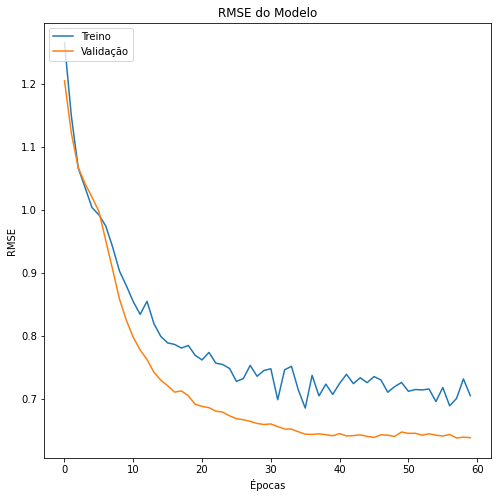

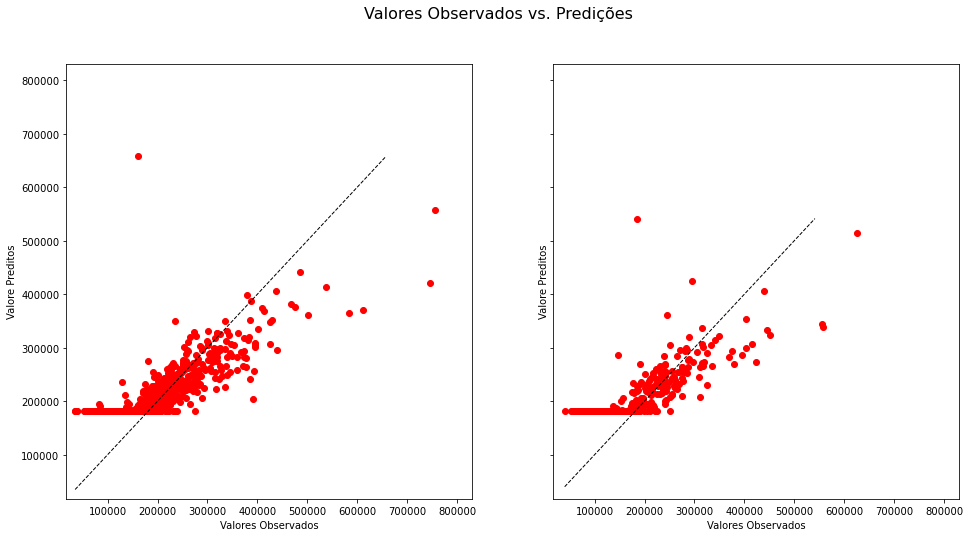

,Treino,Teste,Variação
R²,0.53,0.47,-0.11
RMSE,54720.24,57177.24,0.04


In [22]:
modelo_rna_bl_desemp = preditiva.calcula_desempenho_reg(modelo_rna_bl, 
                                                        x_train_scaled, y_train,
                                                        x_test_scaled,  y_test, y_scaler)
modelo_rna_bl_desemp

## Definição do espaço hiperparamétrico

In [22]:
# Número de camadas de 1 a 5
ehp_layers = np.arange(1, 6, 1)

# Número de neurônios de 2, 4, 8, 16 e 32
ehp_neurons = np.power(2, np.arange(1, 6, 1)) 

# Função de ativação na camada oculta
ehp_fnactiv_hl = ['relu','tanh']
ehp_fnactiv_ol = ['relu','linear']

# Definição do dicionário de parâmetros
param_grid = dict(num_layers=ehp_layers,
                  num_neurons=ehp_neurons,
                  fn_activ_hl=ehp_fnactiv_hl,
                  fn_activ_ol=ehp_fnactiv_ol
                 )

In [23]:
param_grid

{'num_layers': array([1, 2, 3, 4, 5]),
 'num_neurons': array([ 2,  4,  8, 16, 32], dtype=int32),
 'fn_activ_hl': ['relu', 'tanh'],
 'fn_activ_ol': ['relu', 'linear']}

## Random Search

In [29]:
modelo_tf.get_params()

{'model': <function __main__.modelo_DL(num_layers=1, num_neurons=8, fn_activ_hl='tanh', fn_activ_ol='relu')>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x24560a0ae50>,
 'loss': 'mean_squared_error',
 'metrics': <tensorflow.python.keras.metrics.RootMeanSquaredError at 0x245609c2fd0>,
 'batch_size': 32,
 'validation_batch_size': None,
 'verbose': 1,
 'callbacks': <tensorflow.python.keras.callbacks.EarlyStopping at 0x24545419310>,
 'validation_split': 0.2,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 500,
 'num_layers': 1,
 'num_neurons': 8,
 'fn_activ_hl': 'relu',
 'fn_activ_ol': 'relu'}

In [30]:
# Treinamento dos modelos usando Random Search
modelo_random = RandomizedSearchCV(estimator=modelo_tf, 
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   n_jobs=5,
                                   cv=2,
                                   verbose=4)

modelo_random.fit(x_train_scaled, y_train_scaled)

INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp0lnd7s71\assets
Fitting 2 folds for each of 10 candidates, totalling 20 fits
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp8x0_sat9\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpfe4f_on_\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpwyszfoe0\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpwmppr_w5\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp5yiaibl5\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp_3ijmzbe\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmptl8btxu7\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpvsnktwq2\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpadjb7si5\assets
INFO:tensorflow:Assets writte

RandomizedSearchCV(cv=2,
                   estimator=KerasRegressor(batch_size=32, callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x0000024545419310>, epochs=500, fn_activ_hl='relu', fn_activ_ol='relu', loss='mean_squared_error', metrics=<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x00000245609C2FD0>, model=<function modelo_DL at 0x0000024560A6BC10>, num_layers=1, num_neurons=8, optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000024560A0AE50>, validation_split=0.2),
                   n_jobs=5,
                   param_distributions={'fn_activ_hl': ['relu', 'tanh'],
                                        'fn_activ_ol': ['relu', 'linear'],
                                        'num_layers': array([1, 2, 3, 4, 5]),
                                        'num_neurons': array([ 2,  4,  8, 16, 32], dtype=int32)},
                   verbose=4)

In [31]:
modelo_random.best_estimator_

KerasRegressor(
	model=<function modelo_DL at 0x0000024560A6BC10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000024560A0F820>
	loss=mean_squared_error
	metrics=<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x000002455F329340>
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x000002455F329790>
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=500
	num_layers=5
	num_neurons=32
	fn_activ_hl=tanh
	fn_activ_ol=linear
)

14/14 [==============================] - 0s 629us/step


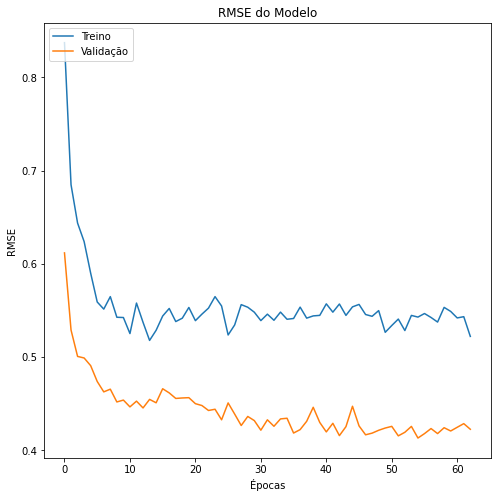

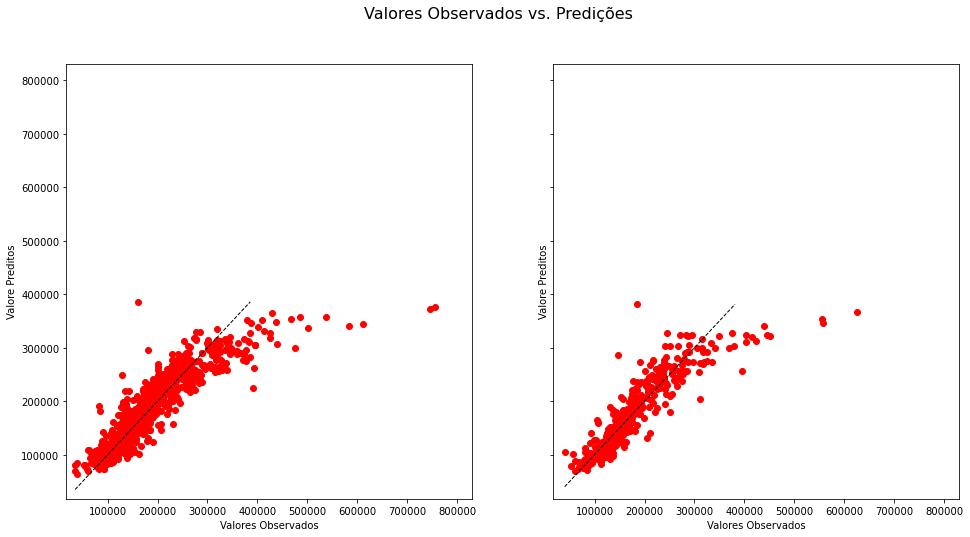

,Treino,Teste,Variação
R²,0.78,0.79,0.01
RMSE,37239.33,36269.50,-0.03


In [32]:
modelo_rna_random = preditiva.calcula_desempenho_reg(modelo_random.best_estimator_,
                                                     x_train_scaled, y_train,
                                                     x_test_scaled,  y_test, y_scaler)
modelo_rna_random

In [33]:
param_grid

{'num_layers': array([1, 2, 3, 4, 5]),
 'num_neurons': array([ 2,  4,  8, 16, 32], dtype=int32),
 'fn_activ_hl': ['relu', 'tanh'],
 'fn_activ_ol': ['relu', 'linear']}

## Grid Search

In [34]:
# Treinamento dos modelos usando Random Search
modelo_grid = GridSearchCV(estimator=modelo_tf, 
                           param_grid=param_grid,
                           n_jobs=6,
                           cv=2,
                           verbose=4)

modelo_grid.fit(x_train_scaled, y_train_scaled)

INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpz2ozosez\assets
Fitting 2 folds for each of 100 candidates, totalling 200 fits
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp0krl298t\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp86dl282e\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpg1o27cpa\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpq0to2fyx\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpt40wwffy\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp8wvua_j8\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp9vmt3xev\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmpo6gyitp1\assets
INFO:tensorflow:Assets written to: C:\Users\Fernando\AppData\Local\Temp\tmp00h5tjzt\assets
INFO:tensorflow:Assets writ

GridSearchCV(cv=2,
             estimator=KerasRegressor(batch_size=32, callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x0000024545419310>, epochs=500, fn_activ_hl='relu', fn_activ_ol='relu', loss='mean_squared_error', metrics=<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x00000245609C2FD0>, model=<function modelo_DL at 0x0000024560A6BC10>, num_layers=1, num_neurons=8, optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000024560A0AE50>, validation_split=0.2),
             n_jobs=6,
             param_grid={'fn_activ_hl': ['relu', 'tanh'],
                         'fn_activ_ol': ['relu', 'linear'],
                         'num_layers': array([1, 2, 3, 4, 5]),
                         'num_neurons': array([ 2,  4,  8, 16, 32], dtype=int32)},
             verbose=4)

In [35]:
modelo_grid.best_estimator_

KerasRegressor(
	model=<function modelo_DL at 0x0000024560A6BC10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000024571034340>
	loss=mean_squared_error
	metrics=<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x0000024571034EE0>
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x0000024571034F10>
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=500
	num_layers=1
	num_neurons=32
	fn_activ_hl=tanh
	fn_activ_ol=linear
)

14/14 [==============================] - 0s 693us/step


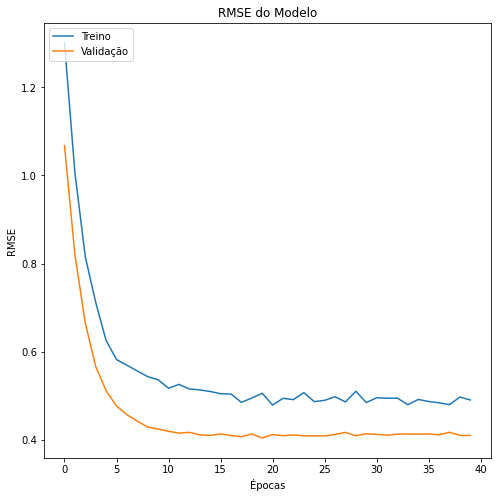

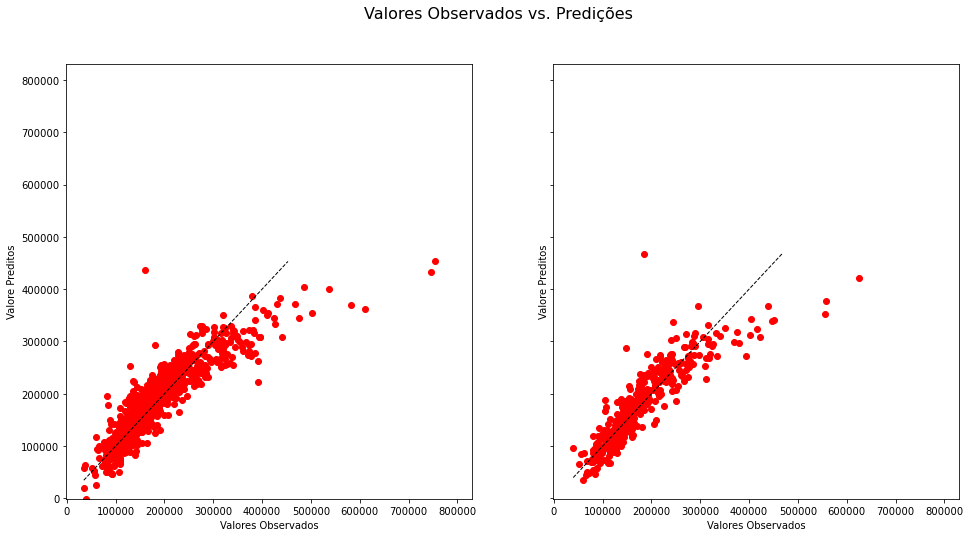

,Treino,Teste,Variação
R²,0.79,0.78,-0.01
RMSE,36193.49,36721.41,0.01


In [37]:
modelo_rna_grid = preditiva.calcula_desempenho_reg(modelo_grid.best_estimator_, 
                                                   x_train_scaled, y_train,
                                                   x_test_scaled,  y_test, y_scaler)
modelo_rna_grid

## Bayesian Optimization

In [20]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys

In [24]:
param_grid

{'num_layers': array([1, 2, 3, 4, 5]),
 'num_neurons': array([ 2,  4,  8, 16, 32], dtype=int32),
 'fn_activ_hl': ['relu', 'tanh'],
 'fn_activ_ol': ['relu', 'linear']}

In [25]:
bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ_hl': hp.choice('fn_activ_hl', param_grid['fn_activ_hl']),
            'fn_activ_ol': hp.choice('fn_activ_ol', param_grid['fn_activ_ol'])
           }

In [26]:
bo_space

{'num_layers': <hyperopt.pyll.base.Apply at 0x293df425400>,
 'num_neurons': <hyperopt.pyll.base.Apply at 0x293baf35d60>,
 'fn_activ_hl': <hyperopt.pyll.base.Apply at 0x293df42cc10>,
 'fn_activ_ol': <hyperopt.pyll.base.Apply at 0x293a2129310>}

In [27]:
def bo_rna(param):   

    print ('Hiperparametros testados: ', param)
    modelo_bo = modelo_DL(num_layers=param['num_layers'], 
                          num_neurons=param['num_neurons'],
                          fn_activ_hl=param['fn_activ_hl'],
                          fn_activ_ol=param['fn_activ_ol']
                         )
    
    modelo_bo.fit(x_train_scaled, 
                  y_train_scaled,
                  epochs=n_epochs,
                  batch_size=n_batchs,
                  validation_split=0.2,
                  #optimizer=keras.optimizers.Adam(),
                  #loss='mean_squared_error', 
                  #metrics=keras.metrics.RootMeanSquaredError(),
                  callbacks=rna_es,
                  verbose=0)
    
    # Calcula RMSE no conjunto de Teste
    y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))
    rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))
    print('RMSE Teste: ', rmse_test)
    
    # sys.stdout.flush() 
    return {'loss': rmse_test, 'status': STATUS_OK}

In [28]:
trials = Trials()
bo_search = fmin(fn=bo_rna, 
                 space=bo_space,
                 algo=tpe.suggest,
                 max_evals=10,
                 trials=trials)

Hiperparametros testados:                                                                                              
{'fn_activ_hl': 'tanh', 'fn_activ_ol': 'relu', 'num_layers': 1, 'num_neurons': 32}                                     
Restoring model weights from the end of the best epoch.                                                                
Epoch 00038: early stopping                                                                                            
RMSE Teste:                                                                                                            
55561.448978844004                                                                                                     
Hiperparametros testados:                                                                                              
{'fn_activ_hl': 'relu', 'fn_activ_ol': 'relu', 'num_layers': 2, 'num_neurons': 16}                                     
Restoring model weights from the end of 

In [45]:
from hyperopt import space_eval

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

Melhor conjunto de hiperparâmetros:  {'fn_activ_hl': 'tanh', 'fn_activ_ol': 'linear', 'num_layers': 1, 'num_neurons': 4}


In [49]:
from hyperopt import space_eval

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

Melhor conjunto de hiperparâmetros:  {'fn_activ_hl': 'tanh', 'fn_activ_ol': 'linear', 'num_layers': 4, 'num_neurons': 8}


In [50]:
modelo_bo = modelo_DL(num_layers=bo_melhor_hp['num_layers'],
                      num_neurons=bo_melhor_hp['num_neurons'],
                      fn_activ_hl=bo_melhor_hp['fn_activ_hl'],
                      fn_activ_ol=bo_melhor_hp['fn_activ_ol']
                     )

historico = modelo_bo.fit(x_train_scaled, 
                          y_train_scaled,
                          epochs=n_epochs,
                          batch_size=n_batchs,
                          validation_split=0.2,
                          callbacks=rna_es,
                          verbose=1)

Epoch 1/500
26/26 [==============================] - 1s 22ms/step - loss: 2.1775 - root_mean_squared_error: 0.9820 - val_loss: 1.9605 - val_root_mean_squared_error: 0.8925
Epoch 2/500
26/26 [==============================] - 0s 2ms/step - loss: 2.0687 - root_mean_squared_error: 0.9555 - val_loss: 1.7532 - val_root_mean_squared_error: 0.8054
Epoch 3/500
26/26 [==============================] - 0s 2ms/step - loss: 1.7352 - root_mean_squared_error: 0.8005 - val_loss: 1.5862 - val_root_mean_squared_error: 0.7345
Epoch 4/500
26/26 [==============================] - 0s 2ms/step - loss: 1.6690 - root_mean_squared_error: 0.7962 - val_loss: 1.4580 - val_root_mean_squared_error: 0.6842
Epoch 5/500
26/26 [==============================] - 0s 2ms/step - loss: 1.6594 - root_mean_squared_error: 0.8238 - val_loss: 1.3610 - val_root_mean_squared_error: 0.6534
Epoch 6/500
26/26 [==============================] - 0s 3ms/step - loss: 1.4516 - root_mean_squared_error: 0.7266 - val_loss: 1.2713 - val_root_

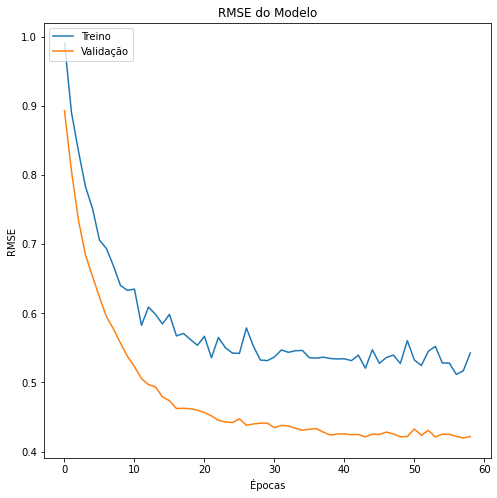

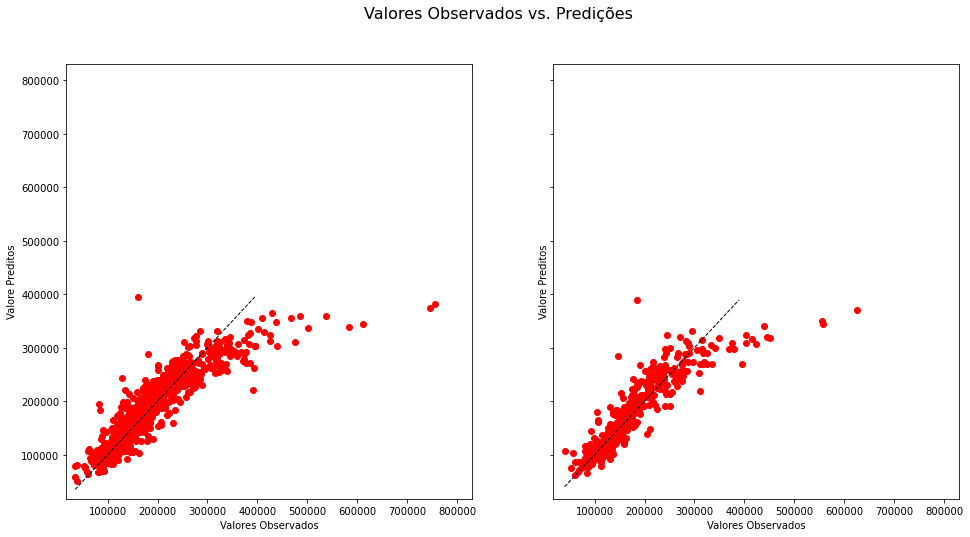

,Treino,Teste,Variação
R²,0.78,0.79,0.01
RMSE,37486.49,36381.69,-0.03


In [51]:
modelo_rna_bo = preditiva.calcula_desempenho_reg(modelo_bo,
                                                 x_train_scaled, y_train,
                                                 x_test_scaled,  y_test,
                                                 y_scaler, historico)
modelo_rna_bo